In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [2]:
retail = pd.read_excel('Online Retail.xlsx', engine='openpyxl')

In [3]:
# quick snippet of the data
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# check the shape of the dataset
observations, variables = retail.shape
print(f'Observations: {observations}')
print(f'Variables: {variables}')

Observations: 541909
Variables: 8


In [5]:
# check for columns types
retail.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

<AxesSubplot:>

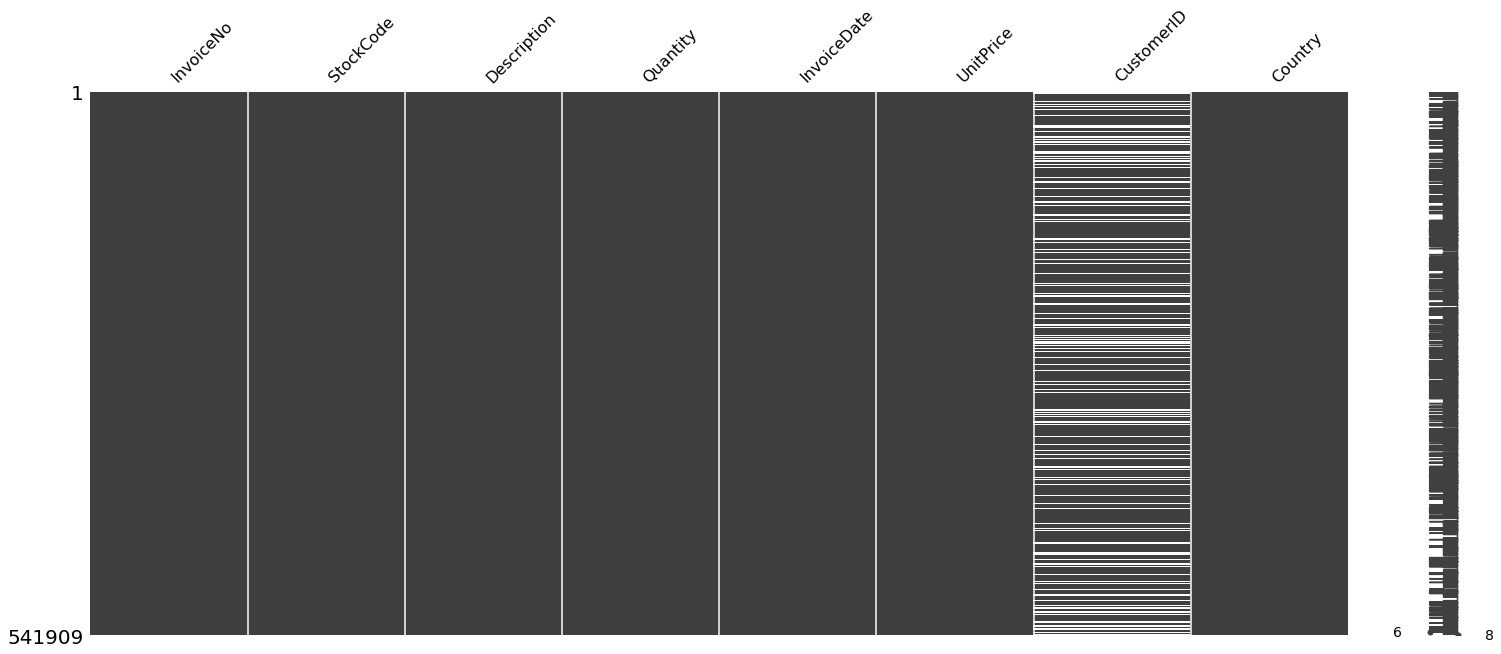

In [6]:
# check for missing values
msno.matrix(retail)

In [7]:
retail[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [8]:
retail[retail['Quantity'] <= 0].sort_values('Quantity', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
255456,C559347,M,Manual,-1,2011-07-07 17:22:00,9.36,18072.0,United Kingdom
256180,C559461,22628,PICNIC BOXES SET OF 3 RETROSPOT,-1,2011-07-08 13:04:00,4.95,14680.0,United Kingdom
256176,C559461,20727,LUNCH BAG BLACK SKULL.,-1,2011-07-08 13:04:00,1.65,14680.0,United Kingdom
256175,C559461,22384,LUNCH BAG PINK POLKADOT,-1,2011-07-08 13:04:00,1.65,14680.0,United Kingdom
...,...,...,...,...,...,...,...,...
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom
225529,556690,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom
225530,556691,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


In [9]:
retail_clean = retail.dropna(subset=['CustomerID']) # drop missing CustomerIDs
retail_clean = retail_clean[retail_clean['Quantity'] > 0] # drop 0 and negative Quantity values
retail_clean = retail_clean[retail_clean['UnitPrice'] > 0] # drop 0 and negative UnitPrice values

In [10]:
# check for highest UnitPrice average
retail_clean.groupby('Description')['UnitPrice'].mean().sort_values(ascending=False).head()

Description
DOTCOM POSTAGE                        744.147500
PICNIC BASKET WICKER 60 PIECES        649.500000
Manual                                175.291585
RUSTIC  SEVENTEEN DRAWER SIDEBOARD    158.076923
REGENCY MIRROR WITH SHUTTERS          156.428571
Name: UnitPrice, dtype: float64

DOTCOM POSTAGE and Manual seem weird products.  
DOTCOM POSTAGE seems to indicate the amount spent by the customer on delivery.  
Manual looks like an additional service that the company offers.  
Since these two isn't a direct indicator of sales, we will drop them.

In [12]:
remove_items = ['DOTCOM POSTAGE', 'Manual']
retail_clean = retail_clean[~retail_clean['Description'].isin(remove_items)]

In [13]:
# check how many duplicates
retail_clean.duplicated().sum()

5187

In [14]:
# drop duplicated observations
retail_clean.drop_duplicates(inplace=True)

In [15]:
# cleaned data set
retail_clean

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


<AxesSubplot:>

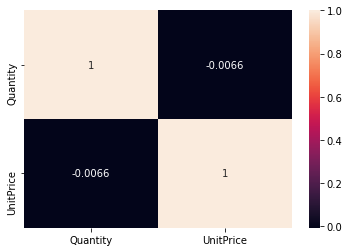

In [16]:
# check for correlation
sns.heatmap(retail_clean[['Quantity', 'UnitPrice']].corr(), annot=True)

<AxesSubplot:ylabel='Country'>

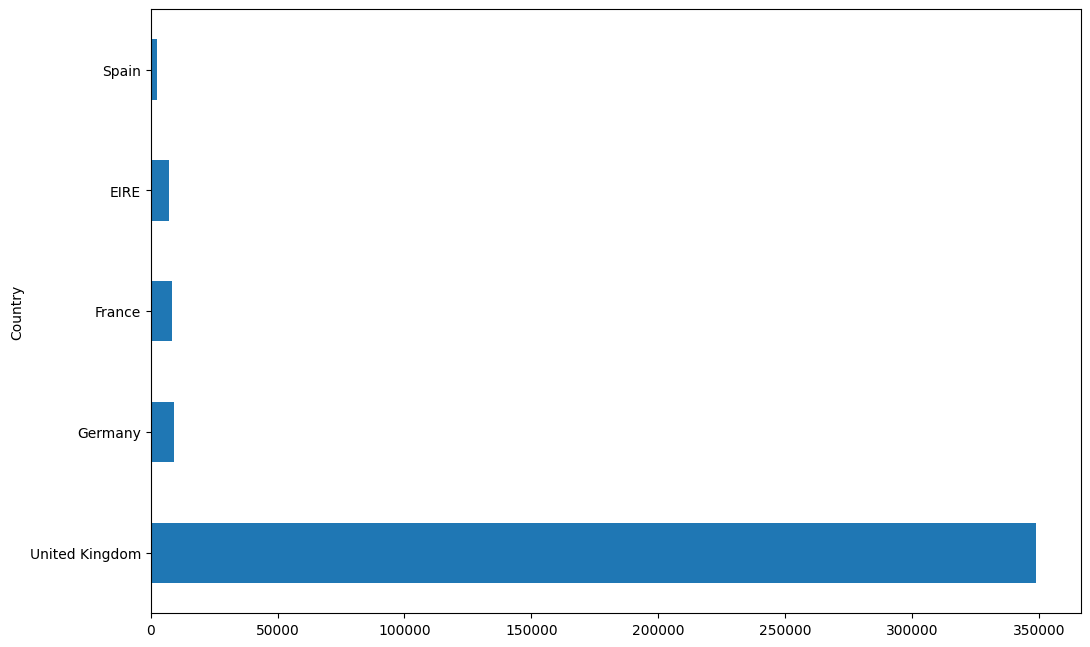

In [17]:
fig = plt.figure(figsize=(12, 8), dpi=100)
retail_clean.groupby('Country')['Quantity'].count().sort_values(ascending=False).head(5).plot.barh()

Most of the sales happened in the UK.  
Since the company is based in the UK, it makes sense.  
So, to properly do customer segmentation, we'll only use the UK transactions.

In [18]:
# only use transactions in the UK
retail_uk = retail_clean[retail_clean['Country'] == 'United Kingdom'].copy()

In [19]:
retail_uk

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [20]:
# create TotalPrice variable
retail_uk['TotalPrice'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [21]:
retail_uk

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.80


In [22]:
# compute total money spent and number of transactions per customer
customer_price = retail_uk.groupby('CustomerID')['TotalPrice'].sum()
customer_count = retail_uk['CustomerID'].value_counts().rename('TransactionCount')
customer = pd.concat([customer_count, customer_price], axis=1)

In [23]:
customer

,TransactionCount,TotalPrice
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4398,31654.78
12749.0,199,4090.88
12820.0,59,942.34
...,...,...
18280.0,10,180.60
18281.0,7,80.82
18282.0,12,178.05
18283.0,719,2039.58


In [24]:
# compute SSE each K
sse = []
K = range(1,11)
for k in K:
    kMeansModel = KMeans(n_clusters=k).fit(customer)
    clusters = kMeansModel.labels_
    sse.append(kMeansModel.inertia_)

Text(0.5, 1.0, 'Elbow Method')

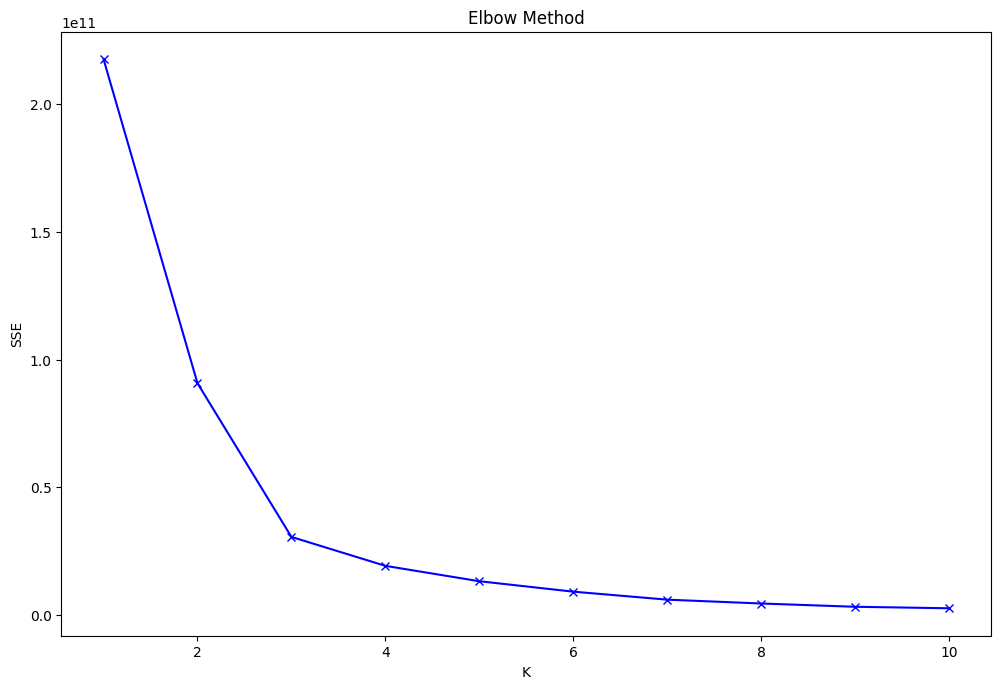

In [25]:
# plot the SSE for elbow method
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.plot(K, sse, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method')

In [26]:
kMeansModel = KMeans(n_clusters=3)
clusters = kMeansModel.fit_predict(customer)

Text(0.5, 1.0, 'Customer Segmentation in United Kingdom')

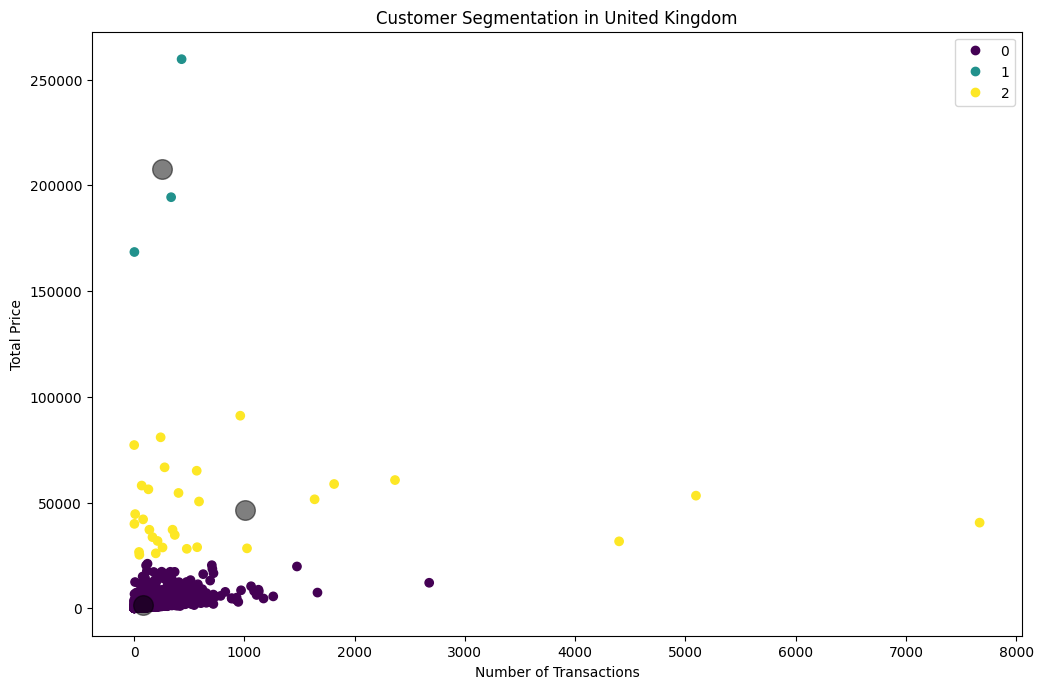

In [28]:
fig = plt.figure(figsize=(12, 8), dpi=100)
scatter = plt.scatter(customer['TransactionCount'], customer['TotalPrice'], c=clusters)
plt.legend(*scatter.legend_elements())

centers = kMeansModel.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.xlabel('Number of Transactions')
plt.ylabel('Total Price')
plt.title('Customer Segmentation in United Kingdom')

In [29]:
# validation using DBI
davies_bouldin_score(customer, clusters)

0.34352262578552795